# Convolutional Networks for CAPTHA Recognition

- Introduction
- Datasets
- CNN MLP Architecture
- Training Preprocess
- Metrics
- Results
- conlusion

## I. Definition


### Project Overview

The CAPTHA Recognition is inspired by the MNINST/SVHN datasets and the hateness of annoying step before logging in or browsing pages. Although this step is for security concern, it is actually not helpful since the spirl of Machine Learning. Lots of websites,including government's sites, still use the  CAPTHAs. This project will reveal that even beginner as I can easily solve CAPTCHAs quickly. it is not only easy to machine to solve, but it annoy human users a lot. Based on the study :"How Good are Humans at Solving CAPTCHAs? A Large Scale Evaluation". it revealed that it is more effective for an attacker touse Mechanical Turk to solve captchas than an underground service.
chrome-extension://oemmndcbldboiebfnladdacbdfmadadm/https://web.stanford.edu/~jurafsky/burszstein_2010_captcha.pdf



### Problem Statement

This problem is a classification of letters by computer vision. Use amounts of CAPTCHAs with various letters' fonts as input data. By Convolutional Netowrks, the CAPTCHAs images can't correctly predicted.
Because the images are formed by numbers 0~9 and letters A~Z, the expected output will be the text of 0~9 and A~Z. 

### Metrics

I use the accuracy and ROC curve to measure the performance of my models. Based on the characteristics of this problem, the score of accuracy must be high. After all, in real scenario, there is no partial right. The ROC curve is to evaluate the true positive rate versus false positive rate. 

## II. Analysis

### Data Preprocessing and Visualization

The CAPTCHAs data samples are from the https://captcha.com/captcha-examples.html
A quantity of samples is 9,000. Every image is formated with 72x24 pixels and the backgrounds are all white. From a example below, the pixels grouping of white are all the same value, but the black areas are distributed with different value. these characteristics don't effect our following analysis. However, the joint between 'W' and 'J' wil be problematic, since the model may consider them as one letter.

There is a simple solution with this problem. we can use the ratio of width versus height to filter this kind feature. if the ratio large than specific value, we can divide the width into half. Futhermore, the postion of numbers and letters are almost at the center of images. Although the vertical position of each number or letter is not the same, the max height and max width of each number or letter are all the same. I can use the characteristic mentioned above to recognize and split the letters.

After I browsed whole datasets, I can sort images into five classes, all letters, all numbers, one number three letters, two numbers two letters and three numbers one letter. The amount of five classes images are almost random and all letters are capital. Except for all numbers and all letters, the sequence of letters and numbers are also random and there are no sign of dominant class; therefore, I can just randomly split the datasets into training/validation/testing.

In [93]:
from IPython.display import Image
display(
#Image(filename = 'C:\\Users\\MLUSER\\Documents\\GitHub\\Udacity\\2A5R.PNG'),
Image(filename = 'C:\\Users\\MLUSER\\Documents\\GitHub\\Udacity\\XWJE.PNG')
)

(24, 72, 3)
uint8
255


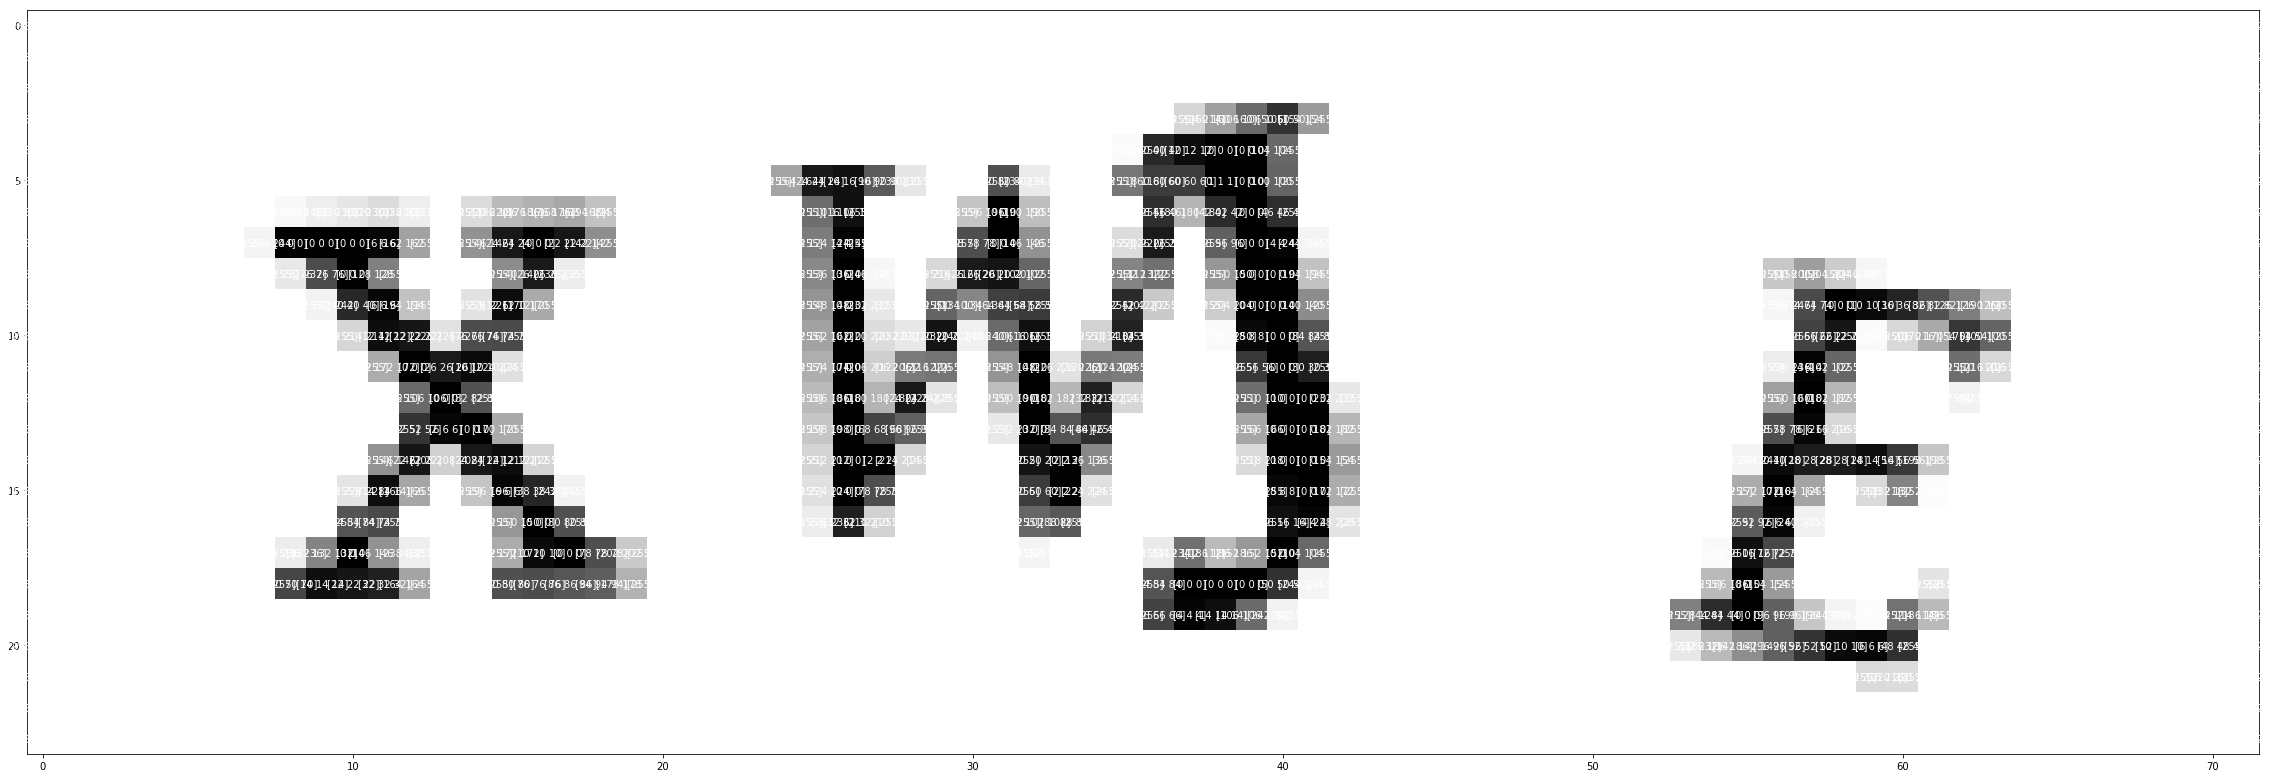

In [91]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.cm as cm
import numpy as np
from PIL import Image
import cv2

image = cv2.imread('C:\\Users\\MLUSER\\Documents\\GitHub\\Udacity\\XWJE.PNG')
print (image.shape)
print (image.dtype)
fig = plt.figure(figsize = (40,40)) 
ax = fig.add_subplot(1,1,1)
ax.imshow(image, cmap='gray')
width= image.shape[0]
height = image.shape[1]
thresh = image.max()
print (thresh)
for x in range(width):
    for y in range(height):
         ax.annotate(str(np.round(image[x][y],2)), xy=(y,x),horizontalalignment='center',verticalalignment='center',color='white' if image[x][y].any() < thresh else 'black')

### Algorithms and Techniques

The algorithms I used is CNN and MLP(the benchmark model). I will explain each layer as follow: 

**Convolutional layer:**

The Convolutional Neural Network(CNN) is structed from Convolutional layer at the first layer.What is  Convolutional layer ? We can imagine the flash light highlight the left-up conrner area of the images pixels. The flash light is called "filter" and the hightlgiht area is called "receptive field". The operation is as below. The filter is a numpy array of weights values and The receptive field is also numpy array. The filter will slide from left-up to right-bottom. Each step dot the weights with pixels to map a new feature. These steps are all summed up then we have new feature map.


**Fully Connected Layer:**

The MLP model is mainly constructed by Fully Connected Layers. we can imagine the filter size is equal the image size. This layer basically takes an N dimensional input images and outputs N dimensional feature map.

**Dropout Layer:**

The dropout layer in neural networks is used to deal with the problem of overfitting, the idea is to drop out a random activation set in that layer. it make sure the network is not too fit to trainig dataset.

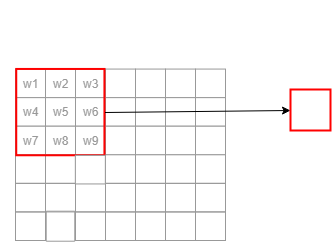

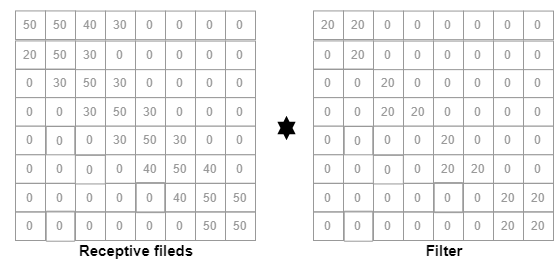

In [104]:
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, Dropout, MaxPooling2D
display(
Image(filename = 'C:\\Users\\MLUSER\\Documents\\GitHub\\Udacity\\machine-learning-master\\projects\\capstone\\CNN.png'),
Image(filename = 'C:\\Users\\MLUSER\\Documents\\GitHub\\Udacity\\machine-learning-master\\projects\\capstone\\CNN1.png')
     )


**MaxPooling Layer:**

The idea of MaxPooling layer is simple. As we know the specific feature in the original input volume and get a feature map from the convolutional layer. the relative relation between each pixel location is important than the actual location, so it takes a filter with size 2x2 normally and a stride of the same length. Then it applies to the input volume and outputs the maximum number in every subregion that the filter convolves around as below schematic. This layer can reduce the spatial dimension of the input volume and also control overfitting.

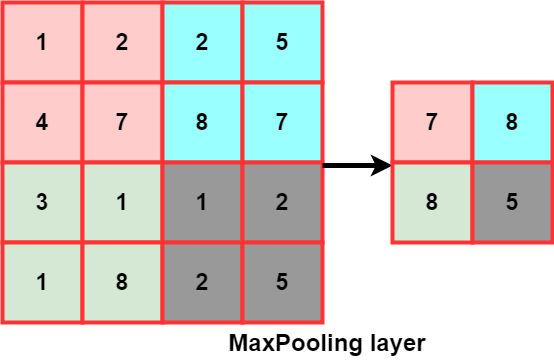

In [103]:
display(
Image(filename = 'C:\\Users\\MLUSER\\Documents\\GitHub\\Udacity\\machine-learning-master\\projects\\capstone\\MaxPool.png')     
     )

## III. Methodology

### Data Preprocessing

At the data preprocessing, I use the OpenCV package to deal with my image datasets. Fisrt of all, the CPATCHAs images look like gray scale; however, I still covert images to gray scale for safty concern:
```python
import cv2
image = cv2.imread(image_file)
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
```
Because there are still different intense black as Analysis discussed, I need to convert the images to pure black and white.
```python
thresh = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
```
After the conversion, it will be easier to find the contours of images. However, as mentioned above, there are joints between letters, so the ratio of width and length of each contour must be examinated. If the the ratio is large than 1.25, the contour may contain two letter. Then the width of this contour will be cut to split into half. each letter will be append into a list of "each_letter_region".
```python
contours = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
```
```python
each_letter_region = []
for contour in contours:
    (x, y, w, h) = cv2.boundingRect(contour)
    if w / h > 1.25:
        half_w = int(w / 2)
        each_letter_region.append((x, y, half_w, h))
        each_letter_region.append((x + half_w, y, half_w, h))
    else:
        each_letter_region.append((x, y, w, h))
```
After all letters are split, sort the list of each_letter_region based on the x coordinate to make sure
left-to-right, so we match the right image with the right letter.
```python
each_letter_region = sorted(each_letter_region, key=lambda x: x[0])
```
Finally, save each letter into one image and put same letter into same file. For example the "M" letter as below.

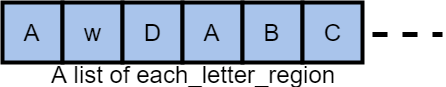

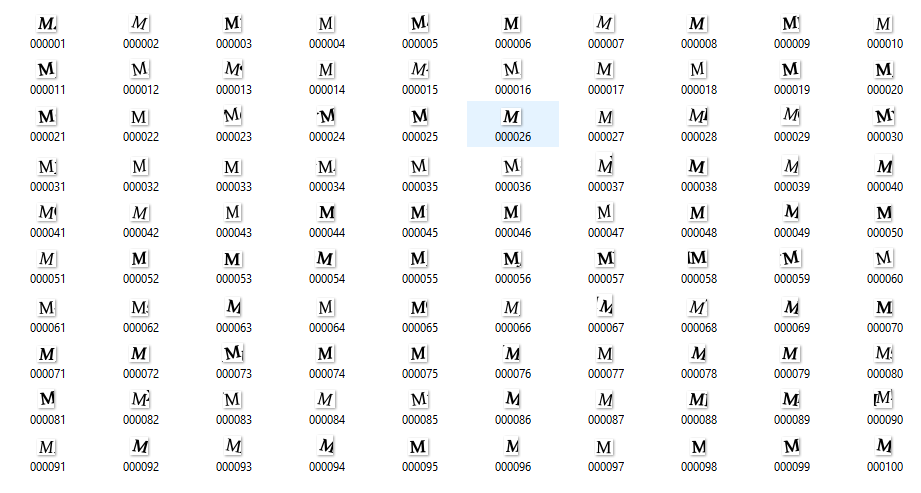

In [128]:
display(
Image(filename = 'C:\\Users\\MLUSER\\Documents\\GitHub\\Udacity\\machine-learning-master\\projects\\capstone\\list.png'),  
Image(filename = 'C:\\Users\\MLUSER\\Documents\\GitHub\\Udacity\\machine-learning-master\\projects\\capstone\\M.png')         
)

### Implementation

I use the Keras to implement my model. For flexible concern, I don't use Sequential Model as usual. I use Model class API to constrcut both MLP and CNN architectures. Therefore, as mentioned above, I import the core layers I will use in architectures:
```python
from keras.models import Model
from keras.layers import Input, Flatten, Dense, Conv2D, Dropout, MaxPooling2D
```
**The benchmark model MLP:**

For computation efficiency, as mentioned above, my input volume resize to (25,25,1) and flatten the input size:
```python
inp = Input(shape=(25,25,1))
flat = Flatten()(inp)
```
Becasue the simple complexity of images and the images are preprocessed, I use two fully connected layers with two dropout layers for overfitting prevention. The activation function are ReLU function ${\displaystyle f(x)=\max(0,x)}$, the dimensionality of the output space are 1000 and 512.
```python
Dense1 = Dense(1000, activation='relu')(flat)
Drop1 = Dropout(0.2)(Dense1)
Dense2 = Dense(512, activation='relu')(Drop1)
Drop2 = Dropout(0.2)(Dense2)
```
The output layer is still fully connected layer with activation function softmax $\sigma (\mathbf {z} )_{j}={\frac {e^{z_{j}}}{\sum _{k=1}^{K}e^{z_{k}}}}$
```python
Dense3 = Dense(32, activation='softmax')(Drop2)      
model = Model(inp,Dense3)
```

**The CNN model:**

The CNN model I used is constructed by two convolutional layers with two maxpooling layers, and then flatten to one fully connected layer. Firtstly, as same as MLP model:
```python
inp = Input(shape=(25,25,1))
```
Then, for convolution layers, the parameter padding is "same", which mean that the output as same as the input. The activation function is also the ReLU like MLP above. For the maxpooling layer, the parameters of pool_size and strides are (2,2) as usual.
```python
conv1 = Conv2D(20, (5, 5), padding="same", activation="relu")(inp)
maxpool1 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(conv1)
conv2 = Conv2D(50,(5,5),padding="same", activation="relu")(maxpool1)
maxpool2 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(conv2)
```
At the last layer, I expect the outputs distribution of probability of each class. Therefore, I use th e Flatten layer to convert the tridimensional tensor into a monodimensional tensor (a vector). Then use two fully connected layers like MLP above. The output activation function is also Softmax, because I want to the distribution of probability of each class.
```python
flat = Flatten()(maxpool2)
dense1 = Dense(500, activation="relu")(flat)
dense2 = Dense(32, activation="softmax")(dense1)
model = Model(inp,dense2)
```

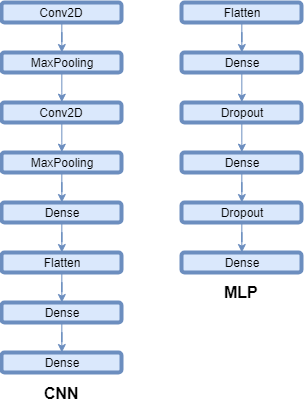

In [29]:
Image(filename = 'C:\\Users\\MLUSER\\Documents\\GitHub\\Udacity\\flow diagram (6).png')

## IV. Results

### Model Evaluation and Validation

Firstly, from the parameters of MLP and CNN, we can find that total parameters of the MLP are more than the total parameters of the CNN. However, the training times of 5 epochs between them, the MLP is 7.25 mins and the CNN is 17.03 mins. At view of computation efficiency, the process times of the CNN is indeed consumable than the MLP. But, we can see the prediction accuracy between them as below. the CNN is more accurate than the MLP. Compare to loss, the conversion of the CNN is quicker than the MLP. If we prolong the training epochs of the MLP to 10 steps, we can observe that the loss fuction is hard to converse, and the accuracy is not improved much.

After training, we save the model parameters and grab some CAPTCHAs from web to see the results.

In [135]:
from keras.models import load_model
MODEL_FILENAME_CNN = "C:\\Users\\MLUSER\\Documents\\GitHub\\Udacity\\machine-learning-master\\projects\\capstone\\CAPTCHA\\solving_captchas\\captcha_model_CNN.hdf5"
MODEL_FILENAME_MLP = "C:\\Users\\MLUSER\\Documents\\GitHub\\Udacity\\machine-learning-master\\projects\\capstone\\CAPTCHA\\solving_captchas\\captcha_model_MLP.hdf5"
model_CNN = load_model(MODEL_FILENAME_CNN)
model_MLP = load_model(MODEL_FILENAME_MLP)
print ("MLP Model")
model_MLP.summary()
print ("\n\nCNN Model")
model_CNN.summary()

MLP Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 25, 25, 1)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 625)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1000)              626000    
_________________________________________________________________
dropout_1 (Dropout)          (None, 1000)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               512512    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 32)                16416     


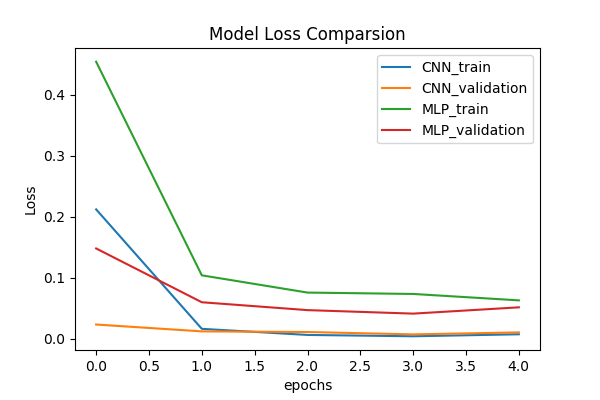

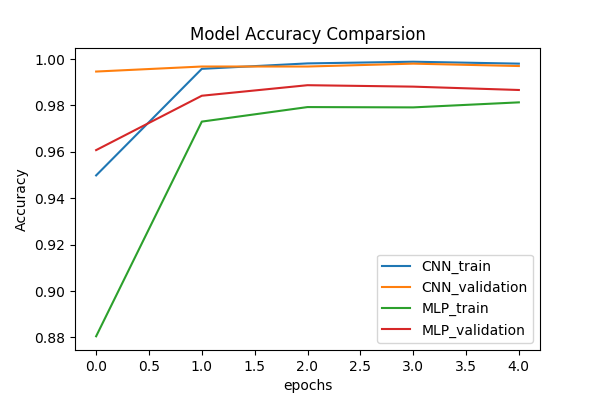

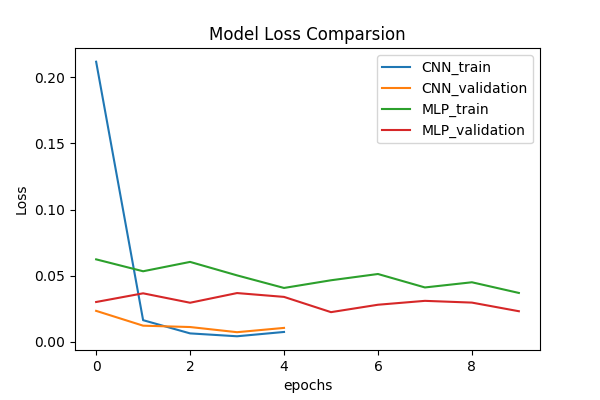

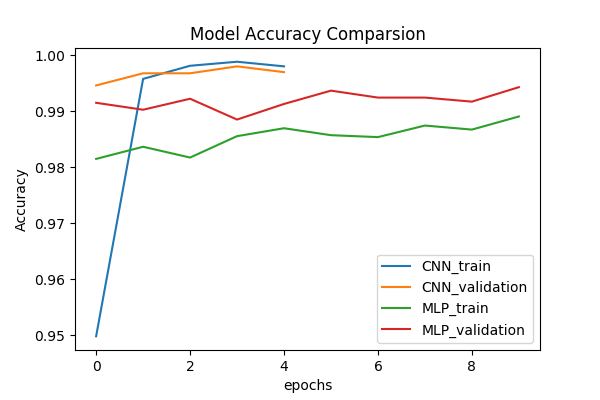

In [136]:
display(
Image(filename = 'C:\\Users\\MLUSER\\Documents\\GitHub\\Udacity\\machine-learning-master\\projects\\capstone\\CAPTCHA\\solving_captchas\\loss.png'),  
Image(filename = 'C:\\Users\\MLUSER\\Documents\\GitHub\\Udacity\\machine-learning-master\\projects\\capstone\\CAPTCHA\\solving_captchas\\acc.png')         
)

## V. Conclusion


### Benchmark Model
I plan to use Multiply Layers Perceptron(MLP) as bechmark models to compare the CNN. The idea is from the MLND projects "cifar10_mlp" and "cifar10_cnn". The CAPTCHAs datasets are well labeled like cifar datasets and even much simplier. I will also use Keras as tool to construct the MLP Model. 




### Project Design

My traing data as below are images with random four letters, numbers and characters. the images files are named as their contents. However, we can find that images with four latters can be split to one letter, then we can use one letter image to train our model. it will reduce our computational time.
Therefore, In image preprocessing, I use findContours() of OpenCV function to split the boundaries of each letter in each image. Then I extract individual letters from images I have and save each letter in it's own folder. So with images preprocessing, our working flow is modified as below. 

The strategy I used is two Convolutional layers with two MaxPooling layers and two fully-connected layers(Dense), one is hidden layer and the others is output layer. I used the Multiply layer perceptron(MLP) as the benchmark model. the architecture as below is two fully-connected layers with two drop out layers. 

<img scr="C:\\Users\\MLUSER\\Documents\\GitHub\\Udacity\\flow diagram.jpg">



### Benchmark Model
I plan to use Multiply Layers Perceptron(MLP) as bechmark models to compare the CNN. The idea is from the MLND projects "cifar10_mlp" and "cifar10_cnn". The CAPTCHAs datasets are well labeled like cifar datasets and even much simplier. I will also use Keras as tool to construct the MLP Model.


## III. Methodology


### Solution Statement
For this kind of image recogition problem, the method flashed into my mind is Convolutional Neural Networks(CNN). Based on the properity of input datasets as mentioned above, at preprocessing step, I will firstly enchance the pixels of letters and numbers images pixels by openCV package, then split each number and letters into same pixels grouping and save them into files named "number(0~9)" or "letter(A~Z)". Secondly, I will map the labels into one-hot encoding by sklearn package. After preprocessing, I will build my CNN model by Keras package with Tensorflow backend. Because the simple complexity of my input datasets, I may just use two convolutional layers to enchance the computaional efficiency. 



### Evaluation Metrics
Fisrt, I may use accuracy to evaluate the CNN and MLP model. Because, in real scenario, there is no tolerance of false judgement rate. Furthermore, The typical CAPTCHAs images, consisted of 0~9 and A~Z, consider  the upper and lower case as the same. Second, the ROC curve I will definitely use as reviewer advice. For MLP and CNN Models, I will test each model by diferent validation folds to verify the rate of true positive versus false positive. 


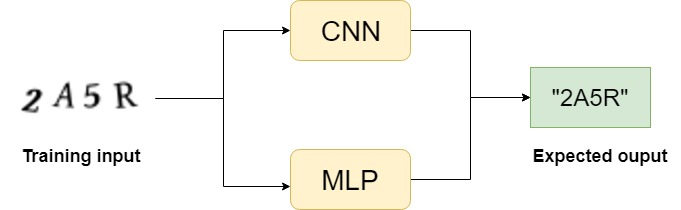

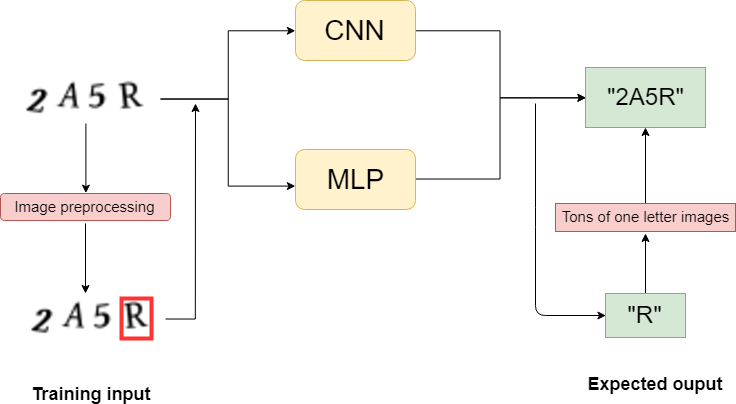

In [34]:
from IPython.display import Image
import nbconvert 
display (
Image(filename = 'C:\\Users\\MLUSER\\Documents\\GitHub\\Udacity\\flow diagram.jpg'),
Image(filename = 'C:\\Users\\MLUSER\\Documents\\GitHub\\Udacity\\flow diagram (9).png')
)


-----------

**Before submitting your proposal, ask yourself. . .**

- Does the proposal you have written follow a well-organized structure similar to that of the project template?
- Is each section (particularly **Solution Statement** and **Project Design**) written in a clear, concise and specific fashion? Are there any ambiguous terms or phrases that need clarification?
- Would the intended audience of your project be able to understand your proposal?
- Have you properly proofread your proposal to assure there are minimal grammatical and spelling mistakes?
- Are all the resources used for this project correctly cited and referenced?